**Homework 2:**
Top university rankings


# topuniversities.com section
Strategy for www.topuniversities.com website:
1. Analysis of web traffic after sending GET request shows that basic informations can be retrived just by getting json file from website.
2. We created DataFrame, from json, which contains basic information and urls to details page of every university.
3. Next step was to analyse detail page structure to obtain as much information as we can. This step make use of BeautifulSoup library.
4. In order to get details of each university we iterated through url and nid attributes of basic DataFrame and downloaded detail page together with json file (containing more information)
5. After downloading detail page we extracted details using BeautifulSoup and create DF. We did that with every university concatenating created DF.
6. At the end we merged (joined) both basic and details DF together on url attribute.
7. Cleaning the data was done in required places.

In [241]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import difflib
import matplotlib.pyplot as plt

In [2]:
# Get basic ranking using the same api as website does. Link comes from analysing web traffic after GET request to topunieversities.com website
top_universities_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508409283658'
r = requests.get(top_universities_url).json()

In [3]:
# Take only first 200 records and put them into DataFrame
top_unis = pd.DataFrame.from_dict(r['data'][:200])
top_unis = top_unis[['rank_display', 'title', 'score', 'cc', 'country', 
       'region', 'url', 'nid']]

In [4]:
details = pd.DataFrame()
for url, nid in zip(top_unis['url'].values, top_unis['nid'].values):
    #print(url)

    req = requests.get('https://www.topuniversities.com' + url)
    soup = BeautifulSoup(req.text, 'html.parser')
    req2 = requests.get('https://www.topuniversities.com/qs-profiles/classifications/' + nid).json()

    d = dict()
    d['url'] = url
    try:
        d['total faculty'] = int(soup.find("div", class_="total faculty").find("div", class_="number").string.strip().replace(",", ""))
        d['inter faculty'] = int(soup.find("div", class_="inter faculty").find("div", class_="number").string.strip().replace(",", ""))
        d['Number of students'] = int(soup.find("div", class_="total student").find("div", class_="number").string.strip().replace(",", ""))
        d['Postgraduate students [%]'] = int(soup.find("div", class_="total student").find("div", class_="post").span.string.strip().replace("%", ""))
        d['Undergraduate students [%]'] = int(soup.find("div", class_="total student").find("div", class_="grad").span.string.strip().replace("%", ""))
        d['Total international students'] = int(soup.find("div", class_="total inter").find("div", class_="number").string.strip().replace(",", ""))
        d['Postgraduate international students [%]'] = int(soup.find("div", class_="total inter").find("div", class_="post").span.string.strip().replace("%", ""))
        d['Undergraduate international students [%]'] = int(soup.find("div", class_="total inter").find("div", class_="grad").span.string.strip().replace("%", ""))

        #for s in soup.find("ul", class_="score").strings:
        #    print(s)

        #soup.find("div", id="wurc").find("ul", class_="score")

        score_type = [elem.string.strip() for elem in soup.find("ul", class_="score").find_all("div", class_="criteria")]
        score_value = [float(elem.string) for elem in soup.find("ul", class_="score").find_all("div", class_="text")]
        lis = list(zip(score_type, score_value))

        d.update(dict((type_, value_) for type_, value_ in lis))
        d.update(req2['classifications'])
        #temp = soup.find("ul", id = "uni-info").find_all("h4")

        #d['Age'] = temp[1].span.string
        #d['Status'] = temp[2].span.string
        #d['Research'] = temp[3].span.string
        #d['Focus'] = temp[4].span.string
        #for element in temp:
        #   d[element.contents[0].strip()] = element.span.string.strip()
    except:
        pass
    details = pd.concat([details, pd.DataFrame.from_dict([d])], ignore_index=True)
    
details.head()

,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Number of students,Overall Score,Postgraduate international students [%],Postgraduate students [%],...,Undergraduate international students [%],Undergraduate students [%],age_value,data_status_value,inter faculty,research_intensity_value,size_value,subject_range_value,total faculty,url
0,100.0,99.9,100.0,100.0,100.0,96.1,11067.0,100.0,83.0,60.0,...,17.0,40.0,5,B,1679.0,VH,M,CO,2982.0,/universities/massachusetts-institute-technolo...
1,100.0,99.4,100.0,100.0,99.6,72.7,15878.0,98.7,83.0,56.0,...,17.0,44.0,5,B,2042.0,VH,L,FC,4285.0,/universities/stanford-university
2,100.0,99.9,100.0,98.3,96.5,75.2,22429.0,98.4,85.0,69.0,...,15.0,31.0,5,B,1311.0,VH,L,FC,4350.0,/universities/harvard-university
3,99.5,100.0,85.4,100.0,93.4,89.2,2255.0,97.7,87.0,56.0,...,13.0,44.0,5,B,350.0,VH,S,CO,953.0,/universities/california-institute-technology-...
4,100.0,78.3,100.0,100.0,97.4,97.7,18770.0,95.6,64.0,37.0,...,36.0,63.0,5,A,2278.0,VH,L,FC,5490.0,/universities/university-cambridge


In [19]:
# Merge of two DF on url column
Total = top_unis.merge(details, left_on='url', right_on='url', how='outer')
# Rename rank column and getting rid of "=" sign in rank column
Total.rename(columns={'rank_display': 'Rank TU'}, inplace=True)
Total['Rank TU'] = Total['Rank TU'].str.replace("=", "")
Total

,Rank TU,title,score,cc,country,region,url,nid,Academic Reputation,Citations per Faculty,...,Total international students,Undergraduate international students [%],Undergraduate students [%],age_value,data_status_value,inter faculty,research_intensity_value,size_value,subject_range_value,total faculty
0,1,Massachusetts Institute of Technology (MIT),100,US,United States,North America,/universities/massachusetts-institute-technolo...,294850,100.0,99.9,...,3717.0,17.0,40.0,5,B,1679.0,VH,M,CO,2982.0
1,2,Stanford University,98.7,US,United States,North America,/universities/stanford-university,297282,100.0,99.4,...,3611.0,17.0,44.0,5,B,2042.0,VH,L,FC,4285.0
2,3,Harvard University,98.4,US,United States,North America,/universities/harvard-university,294270,100.0,99.9,...,5266.0,15.0,31.0,5,B,1311.0,VH,L,FC,4350.0
3,4,California Institute of Technology (Caltech),97.7,US,United States,North America,/universities/california-institute-technology-...,294562,99.5,100.0,...,647.0,13.0,44.0,5,B,350.0,VH,S,CO,953.0
4,5,University of Cambridge,95.6,GB,United Kingdom,Europe,/universities/university-cambridge,294561,100.0,78.3,...,6699.0,36.0,63.0,5,A,2278.0,VH,L,FC,5490.0
5,6,University of Oxford,95.3,GB,United Kingdom,Europe,/universities/university-oxford,294654,100.0,76.3,...,7353.0,26.0,56.0,5,A,2964.0,VH,L,FC,6750.0
6,7,UCL (University College London),94.6,GB,United Kingdom,Europe,/universities/ucl-university-college-london,294014,99.7,74.7,...,14854.0,45.0,52.0,5,A,2554.0,VH,XL,FC,6345.0
7,8,Imperial College London,93.7,GB,United Kingdom,Europe,/universities/imperial-college-london,294030,99.4,68.7,...,8746.0,47.0,57.0,5,A,2071.0,VH,L,FC,3930.0
8,9,University of Chicago,93.5,US,United States,North America,/universities/university-chicago,294536,99.9,85.9,...,3379.0,24.0,43.0,5,B,635.0,VH,L,FC,2449.0
9,10,ETH Zurich - Swiss Federal Institute of Techno...,93.3,CH,Switzerland,Europe,/universities/eth-zurich-swiss-federal-institu...,294432,99.6,98.7,...,7563.0,28.0,47.0,5,A,1886.0,VH,L,CO,2477.0


# timeshighereducation.com section
Strategy for www.timeshighereducation.com:
1. Similarly as in previous task we analysed web traffic (Postman app or Developer tools) after sending GET request and found an url to the json file with all needed informations. DataFrame was created using that json file.
2. Besides data cleaning and renaming or droping attributes, no futher actions were applied because of very handy json file structure.

In [345]:
times_rank_url = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(times_rank_url).json()

In [346]:
top_unis_times = pd.DataFrame.from_dict(r['data'][:200])

In [347]:
top_unis_times['stats_number_students'] = top_unis_times.stats_number_students.str.replace(",", "")

In [348]:
top_unis_times.columns

Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')

In [349]:
times_relevant_columns = ['rank', 'name', 'location',  
       'scores_citations', 'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio']

top_unis_times = top_unis_times[times_relevant_columns]

top_unis_times['rank'] = top_unis_times['rank'].str.replace("=", "").apply(pd.to_numeric)

Now we want to obtain some information from the rankings.

Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

In [350]:
top_unis_times

,rank,name,location,scores_citations,scores_citations_rank,scores_industry_income,scores_industry_income_rank,scores_international_outlook,scores_international_outlook_rank,scores_overall,scores_overall_rank,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,1,University of Oxford,United Kingdom,99.1,15,63.7,169,95.0,24,94.3,10,99.5,1,86.7,5,46 : 54,20409,38%,11.2
1,2,University of Cambridge,United Kingdom,97.5,29,51.5,260,93.0,35,93.2,20,97.8,3,87.8,3,45 : 55,18389,35%,10.9
2,3,California Institute of Technology,United States,99.5,10,92.6,51,59.7,322,93.0,30,97.5,4,90.3,1,31 : 69,2209,27%,6.5
3,3,Stanford University,United States,99.9,4,60.5,189,77.6,162,93.0,40,96.7,5,89.1,2,42 : 58,15845,22%,7.5
4,5,Massachusetts Institute of Technology,United States,100.0,1,88.4,63,87.6,81,92.5,50,91.9,9,87.3,4,37 : 63,11177,34%,8.7
5,6,Harvard University,United States,99.7,8,46.4,330,79.7,143,91.8,60,98.4,2,84.2,9,None,20326,26%,8.9
6,7,Princeton University,United States,99.6,9,58.0,204,78.7,152,91.1,70,93.9,6,85.7,7,45 : 55,7955,24%,8.3
7,8,Imperial College London,United Kingdom,96.7,40,71.6,120,96.6,13,89.2,80,88.7,12,81.7,13,37 : 63,15857,55%,11.4
8,9,University of Chicago,United States,99.4,12,39.8,487,69.6,231,88.6,90,90.1,10,85.3,8,44 : 56,13525,25%,6.2
9,10,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,94.3,60,60.3,190,98.1,8,87.7,100,92.0,8,76.4,21,31 : 69,19233,38%,14.6


In [351]:
top_unis_times['stats_student_staff_ratio'] = top_unis_times['stats_student_staff_ratio'].apply(pd.to_numeric)
best_faculty_ratio = top_unis_times['stats_student_staff_ratio'].sort_values().head(10)
best_faculty_ratio.index
top_unis_times.loc[best_faculty_ratio.index][['name','rank','stats_student_staff_ratio']]

,name,rank,stats_student_staff_ratio
105,Vanderbilt University,105,3.3
109,University of Copenhagen,109,4.1
12,Johns Hopkins University,13,4.3
11,Yale University,12,4.3
153,University of Rochester,153,4.3
97,Emory University,98,4.4
16,Duke University,17,4.5
114,École Polytechnique,115,5.1
183,Scuola Normale Superiore di Pisa,184,5.2
101,University of Pittsburgh,100,5.9


In [352]:
top_unis_times['stats_pc_intl_students'].dtype
top_unis_times['stats_pc_intl_students'] = top_unis_times['stats_pc_intl_students'].str.strip('%').apply(pd.to_numeric)

In [353]:
best_intl_desc = top_unis_times['stats_pc_intl_students'].sort_values(ascending=False).head(10)
best_intl_asc = top_unis_times['stats_pc_intl_students'].sort_values(ascending=True).head(10)

In [354]:
top_unis_times.loc[best_intl_desc.index][['name','rank','stats_pc_intl_students']]

,name,rank,stats_pc_intl_students
24,London School of Economics and Political Science,25,71
178,University of Luxembourg,179,57
7,Imperial College London,8,55
37,École Polytechnique Fédérale de Lausanne,38,55
102,Maastricht University,103,50
15,University College London,16,49
143,University of St Andrews,143,48
120,Queen Mary University of London,121,45
23,Carnegie Mellon University,24,45
39,University of Hong Kong,40,42


In [355]:
top_unis_times.loc[best_intl_asc.index][['name','rank','stats_pc_intl_students']]

,name,rank,stats_pc_intl_students
131,University of Science and Technology of China,132,3
161,"University of California, Santa Cruz",162,4
136,Pohang University of Science and Technology,137,4
188,Shanghai Jiao Tong University,188,6
177,Zhejiang University,177,6
167,University of Alabama at Birmingham,168,6
89,University of Helsinki,90,6
183,Scuola Normale Superiore di Pisa,184,7
173,University of Münster,173,7
67,Utrecht University,68,7


**Aggregating by country and region**

In [356]:
times_by_country = top_unis_times.groupby(by='location').mean()

times_by_country['stats_student_staff_ratio'].sort_values().head(10)

location
Russian Federation     7.300000
Japan                  7.700000
Denmark                8.133333
Italy                  8.450000
Taiwan                11.500000
South Africa          11.700000
United States         11.904839
China                 11.942857
South Korea           13.300000
France                13.450000
Name: stats_student_staff_ratio, dtype: float64

In [357]:
times_by_country['stats_pc_intl_students'].sort_values(ascending=False).head(10)

location
Luxembourg        57.000000
United Kingdom    36.548387
Hong Kong         32.800000
Switzerland       31.428571
Australia         30.750000
Singapore         30.500000
New Zealand       29.000000
Ireland           27.000000
Austria           26.000000
Canada            22.500000
Name: stats_pc_intl_students, dtype: float64

In [358]:
times_by_country['stats_pc_intl_students'].sort_values(ascending=True).head(10)

location
Taiwan          8.000000
China           8.571429
Japan           9.000000
South Korea     9.000000
Italy          10.500000
Finland        13.000000
Spain          14.000000
Sweden         14.000000
Germany        15.200000
Denmark        16.666667
Name: stats_pc_intl_students, dtype: float64

The Times Higher Education data does not contain region information, just the country. Therefore we need to infer the region from country. To do this, we use the QS data set which contains both countries and regions to map countries in the Times Higher Education data set to regions.

In [359]:
top_unis_times['region_the'] = np.nan
top_unis
country_region_map = {}
for index,entry in top_unis.iterrows():
    if entry['country'] not in country_region_map:
        country_region_map[entry['country']] = entry['region']
country_region_map

{'Argentina': 'Latin America',
 'Australia': 'Oceania',
 'Austria': 'Europe',
 'Belgium': 'Europe',
 'Brazil': 'Latin America',
 'Canada': 'North America',
 'Chile': 'Latin America',
 'China': 'Asia',
 'Denmark': 'Europe',
 'Finland': 'Europe',
 'France': 'Europe',
 'Germany': 'Europe',
 'Hong Kong': 'Asia',
 'India': 'Asia',
 'Ireland': 'Europe',
 'Israel': 'Asia',
 'Italy': 'Europe',
 'Japan': 'Asia',
 'Malaysia': 'Asia',
 'Mexico': 'Latin America',
 'Netherlands': 'Europe',
 'New Zealand': 'Oceania',
 'Norway': 'Europe',
 'Russia': 'Europe',
 'Saudi Arabia': 'Asia',
 'Singapore': 'Asia',
 'South Africa': 'Africa',
 'South Korea': 'Asia',
 'Spain': 'Europe',
 'Sweden': 'Europe',
 'Switzerland': 'Europe',
 'Taiwan': 'Asia',
 'United Kingdom': 'Europe',
 'United States': 'North America'}

In [360]:
for index,entry in top_unis_times.iterrows():
    if entry['location'] in country_region_map:
        top_unis_times.loc[index,'region_the'] = country_region_map[entry['location']]
        
for index,row in enumerate(top_unis_times['region_the'].isnull()):
    if row != False:
        print(index)

178
193


In [361]:
top_unis_times.loc[[178,193]][['location','region_the']]
# Luxembourg is not in QS data, Russia is written as Russia in QS data
# and as Russian Federation in Times Higher Education data

,location,region_the
178,Luxembourg,NaN
193,Russian Federation,NaN


In [362]:
top_unis_times.loc[178,'region_the'] = 'Europe'
top_unis_times.loc[193,'region_the'] = 'Europe'
top_unis_times['region_the'].isnull().any()

False

In [363]:
times_by_region = top_unis_times.groupby(by='region_the').mean()

times_by_region['stats_student_staff_ratio'].sort_values().head()

region_the
Africa           11.700000
North America    12.594118
Asia             13.976190
Europe           21.371287
Oceania          26.500000
Name: stats_student_staff_ratio, dtype: float64

In [364]:
times_by_region['stats_pc_intl_students'].sort_values(ascending=False)

region_the
Oceania          30.555556
Europe           24.465347
North America    18.558824
Africa           18.000000
Asia             16.523810
Name: stats_pc_intl_students, dtype: float64

In [365]:
times_by_region['stats_pc_intl_students'].sort_values(ascending=True)

region_the
Asia             16.523810
Africa           18.000000
North America    18.558824
Europe           24.465347
Oceania          30.555556
Name: stats_pc_intl_students, dtype: float64

In [372]:
best_faculty_ratio
#list(top_unis_times.loc[best_faculty_ratio.index]['name'].values)
#best_faculty_ratio.values
best_intl_desc

24     71
178    57
7      55
37     55
102    50
15     49
143    48
120    45
23     45
39     42
Name: stats_pc_intl_students, dtype: int64

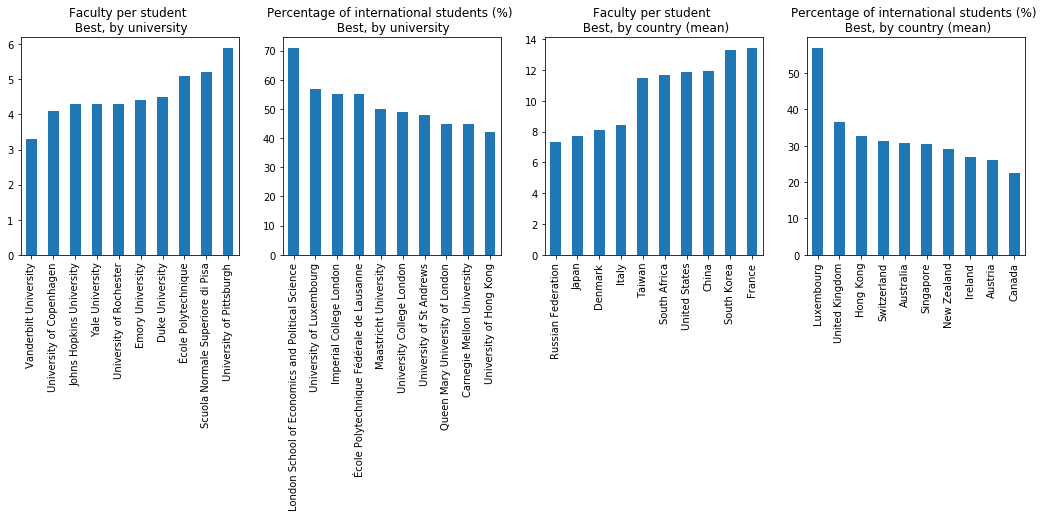

In [388]:
#plt.bar(['a','b','c'],[1,2,3])
#plt.bar(list(top_unis_times.loc[best_faculty_ratio.index]['name'].values),[0,1,2,3,4,5,6,7,8,9])
#list(best_faculty_ratio.values)
#plt.bar([1, 2, 3, 4], [1, 4, 9, 16],)
#best_faculty_ratio.plot(x=top_unis_times.loc[best_faculty_ratio.index]['name'],kind='bar')
#best_faculty_ratio.plot(kind='bar')
#plt.xticks(list(best_faculty_ratio.index),['a','s','d','f','g','h','j','k','l','p'])
#plt.xticks(range(0,10),['a','s','d','f','g','h','j','k','l','p'])

fig,axs = plt.subplots(1,4)
fig.set_figwidth(18)

plt.sca(axs[0])
best_faculty_ratio.plot(kind='bar')
plt.xticks(range(0,10),list(top_unis_times.loc[best_faculty_ratio.index]['name'].values))
plt.title('Faculty per student \n Best, by university')

plt.sca(axs[1])
best_intl_desc.plot(kind='bar')
plt.xticks(range(0,10),list(top_unis_times.loc[best_intl_desc.index]['name'].values))
plt.title('Percentage of international students (%) \n Best, by university')

plt.sca(axs[2])
times_by_country['stats_student_staff_ratio'].sort_values().head(10).plot(kind='bar')
plt.title('Faculty per student \n Best, by country (mean)')
plt.xlabel('')

plt.sca(axs[3])
times_by_country['stats_pc_intl_students'].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Percentage of international students (%) \n Best, by country (mean)')
plt.xlabel('')

plt.show()

# Merging both ranking DataFrames
Strategy:
1. We checked how many of university names overlap (105).
2. We looked at those which were not matched and found out that many of them have an abbreviation at the end, so we deleted them using regex to find every string that contains parentheses, for example '(MIT)' or '(EPFL)'.
3. After that operation there were 119 matched universities.
4. Another differentiating thing was the word `The` at the beginning of universities' names (139 matched).
5. At the end we used difflib library and its `get_close_matches` function iteratively with different cutoff parameter to find best matches between not matched names. That part required more manual assigning.
6. We ended up with 160 matched universities.
7. Merging was made on respectively `name` and `title` columns.

In [ ]:
matching_names_total_in_times = np.array([title in top_unis_times['name'].values for title in Total['title'].values])
matching_names_total_in_times

This names were not matched between `Total` and `top_unis_times`

In [ ]:
not_matched = Total[~matching_names_total_in_times].title.values
print(len(not_matched))

In [ ]:
Total.loc[Total['title'] == 'UCL (University College London)', 'title'] = 'University College London'
top_unis_times.loc[top_unis_times['name'] == 'ETH Zurich – Swiss Federal Institute of Technology Zurich'
                   , 'name'] = 'ETH Zurich - Swiss Federal Institute of Technology'
Total.loc[Total['title'] == 'Ecole Polytechnique Fédérale de Lausanne (EPFL)', 'title'] = 'École Polytechnique Fédérale de Lausanne'

In [ ]:
for not_match in not_matched:
    Total.loc[Total['title'] == not_match, 'title'] = re.sub(r"\((.*?)\)", "" , not_match).strip()

In [ ]:
matching_names_total_in_times_2 = np.array([title in top_unis_times['name'].values for title in Total['title'].values])
print(np.count_nonzero(matching_names_total_in_times_2))

Plenty of names differ only by a `The` at the beginning of a `name`

In [ ]:
similar = [(elem, difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.7)[0]) for elem in Total[~matching_names_total_in_times_2].title.values if difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.7) != []]
len(similar)

In [ ]:
for not_match in Total[~matching_names_total_in_times_2].title.values:
    Total.loc[Total['title'] == not_match, 'title'] = re.sub(r"^(The)\s", "" , not_match)

In [ ]:
matching_names_total_in_times_3 = np.array([title in top_unis_times['name'].values for title in Total['title'].values])
print(np.count_nonzero(matching_names_total_in_times_3))

In [ ]:
similar2 = [(elem, difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.4)[0]) 
            for elem in Total[~matching_names_total_in_times_3].title.values 
            if difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.4) != []]

In [ ]:
names = [("King's College London", 'King’s College London'),
         ('KAIST - Korea Advanced Institute of Science & Technology',
          'Korea Advanced Institute of Science and Technology (KAIST)'),
         ('Ecole Polytechnique', 'École Polytechnique'),
         ('Pohang University of Science And Technology',
          'Pohang University of Science and Technology'),
         ('University of North Carolina, Chapel Hill',
          'University of North Carolina at Chapel Hill'),
         ('Washington University in St. Louis', 'Washington University in St Louis'),
         ('KIT, Karlsruhe Institute of Technology',
          'Karlsruhe Institute of Technology'),
         ('Humboldt-Universität zu Berlin', 'Humboldt University of Berlin'),
         ('Freie Universitaet Berlin', 'Free University of Berlin'),
         ('Université de Montréal', 'University of Montreal'),
         ('Technische Universität Berlin', 'Technical University of Berlin'),
         ('Université catholique de Louvain', 'Université Catholique de Louvain'),
         ('Trinity College Dublin, The University of Dublin',
          'Trinity College Dublin'),
         ("Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento",
          'Scuola Superiore Sant’Anna'),
         ('Universitat Autònoma de Barcelona', 'Autonomous University of Barcelona'),
         ('Eberhard Karls Universität Tübingen', 'University of Tübingen')]
         
for total_name, top_unis_name in names:        
    Total.loc[Total['title'] == total_name, 'title'] = top_unis_name

In [ ]:
matching_names_total_in_times_4 = np.array([title in top_unis_times['name'].values for title in Total['title'].values])
print(np.count_nonzero(matching_names_total_in_times_4))

In [ ]:
matching_names_times_in_total = np.array([title in Total['title'].values for title in top_unis_times['name'].values])
print(np.count_nonzero(matching_names_times_in_total))

In [ ]:
similar3 = [(elem, difflib.get_close_matches(elem, top_unis_times[~matching_names_times_in_total].name.values, cutoff = 0.2)) 
            for elem in Total[~matching_names_total_in_times_4].title.values]

In [ ]:
names2 = [('Ludwig-Maximilians-Universität München', 'LMU Munich'),
         ('Ruprecht-Karls-Universität Heidelberg', 'Heidelberg University'),
         ('Université Pierre et Marie Curie', 'Pierre and Marie Curie University'),
         ('Wageningen University', 'Wageningen University & Research'),
         ('Albert-Ludwigs-Universitaet Freiburg', 'University of Freiburg')]

for total_name, top_unis_name in names2:        
    Total.loc[Total['title'] == total_name, 'title'] = top_unis_name

In [ ]:
matching_names_times_in_total = np.array([title in Total['title'].values for title in top_unis_times['name'].values])
print(np.count_nonzero(matching_names_times_in_total))

In [ ]:
Full_ranking = Total.merge(top_unis_times, left_on='title', right_on='name', how='inner')
Full_ranking[['title', 'Rank TU', 'rank']]